### Курсовой проект по курсу "Python для Data Science"

Info
Материалы к проекту (файлы): train.csv test.csv

Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Целевая переменная: Price

Основная метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика: MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

In [907]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели
from scipy import stats
import random 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2


In [908]:
import warnings
warnings.filterwarnings('ignore')

### Описание датасета

'Id' идентификационный  номер квартиры 

 'DistrictId' идентификационный  номер района
 
 'Rooms' количество  комнат
 
 'Square' общая площадь  квартиры
 
 'LifeSquare' жилая  площадь
 
 'KitchenSquare' площадь кухни
 
 'Floor'этаж
 
 'HouseFloor' количество этажей в доме
 
 'HouseYear' год постройки  дома
 
 'Ecology_1', 'Ecology_2', 'Ecology_3'  экологичесмкие показатели  дома
 
 'Social_1', 'Social_2', Social_3'  социальные показатели  местности 
 
 'Healthcare_1', 'Helthcare_2' показатели  местности, связанные с охраной здоровья
 
 'Shops_1', 'Shops_2'  показетели местности связанные с наличием магазинов
 
 'Price' цена квартиры

In [909]:
# создание переменной с указанием на  путь к файлу
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

In [910]:
#загрузка датафрейма
df_train = pd.read_csv(TRAIN_DATASET_PATH, ',')
df_train.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


In [911]:
#получение списка столбцjd  для  формирования  описания  датасета
df_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [912]:
# тестовый датасет
df_test = pd.read_csv(TEST_DATASET_PATH, ',')
df_test.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
5,7633,53,1.0,40.675627,NaN,1.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
6,13329,23,2.0,68.099538,64.843025,1.0,2,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
7,5502,32,2.0,48.193897,32.857644,6.0,5,14.0,1972,0.135650,B,B,46,7960,6,350.0,3,11,B
8,4220,96,3.0,72.277106,45.968758,9.0,17,17.0,1997,0.041116,B,B,53,14892,4,NaN,1,4,B
9,11538,6,3.0,80.219400,47.660260,9.0,13,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B


In [913]:
#размер датафрейма train
print(f'Размер train датафрейма "Цены на недвижимость (квартиры)" -  строк {df_train.shape[0]}, столбцов {df_train.shape[1]}')
#размер датафрейма test
print(f'Размер train датафрейма "Цены на недвижимость (квартиры)" -  строк {df_test.shape[0]}, столбцов {df_test.shape[1]}')

Размер train датафрейма "Цены на недвижимость (квартиры)" -  строк 10000, столбцов 20
Размер train датафрейма "Цены на недвижимость (квартиры)" -  строк 5000, столбцов 19


array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>],
       [<AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>],
       [<AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>],
       [<AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>],
       [<AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

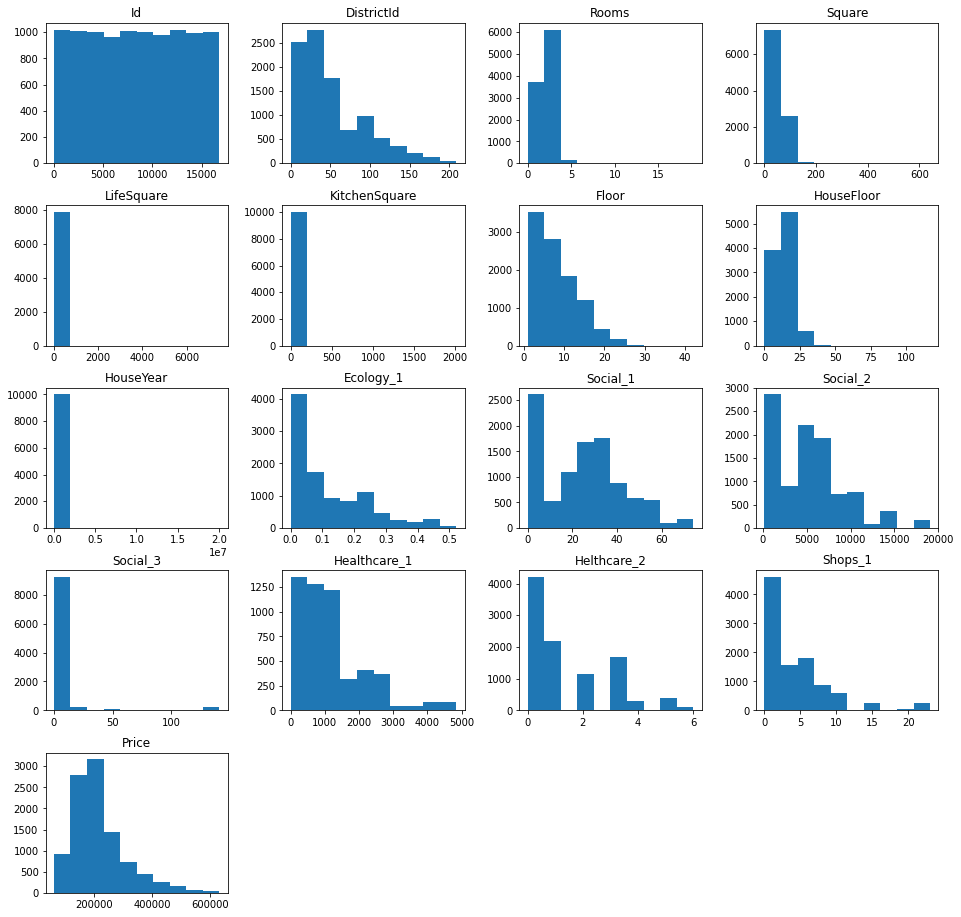

In [914]:
df_train.hist(figsize = (16,16), bins = 10, grid = False)

In [915]:
#Выведем информацию о датафрейме  train, аргумент memory_usage='deep' отражает  использование памяти :
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [916]:
#Выведем информацию о датафрейме  train, аргумент memory_usage='deep' отражает  использование памяти :
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

### Оптимизация датасета и памяти 

In [917]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [918]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [919]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [920]:
#Признак Rooms - только целочисленный.... конвертируем float --> int
df_train['Rooms'] = df_train['Rooms'].astype('int8')
df_test['Rooms'] = df_test['Rooms'].astype('int8')
#Признак HouseFloor - только целочисленный....
df_train['HouseFloor'] = df_train['HouseFloor'].astype('int8')
df_test['HouseFloor'] = df_test['HouseFloor'].astype('int8')

In [921]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  int8    
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int8    
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

### Количественные данные

In [922]:
df_num_features = df_train.select_dtypes(include=['int8', 'int16', 'int32','float'])
df_num_features.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,33,7976,5,NaN,0,11,184966.937500
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,46,10309,1,240.0,1,16,300009.437500
2,4765,53,2,44.947952,29.197611,0.0,8,12,1968,0.049637,34,7759,0,229.0,1,3,220925.906250
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,23,5735,3,1084.0,0,5,175616.234375
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,35,5776,1,2078.0,2,4,150226.531250
5,12915,59,3,80.384476,46.683720,12.0,5,17,2011,0.309479,35,7715,4,990.0,0,6,215898.453125
6,14549,154,2,62.254112,37.160378,7.0,3,5,1960,0.460556,20,4386,14,NaN,1,5,296021.218750
7,11993,74,2,80.312927,NaN,0.0,14,0,1977,0.075779,6,1437,3,NaN,0,2,221244.156250
8,5172,1,2,64.511436,NaN,1.0,9,17,1977,0.007122,1,264,0,NaN,0,1,229102.796875
9,8649,23,1,46.461411,18.915552,8.0,13,17,2014,0.075779,6,1437,3,NaN,0,2,95380.218750


In [923]:
# размер датафрейма df_num_features
df_num_features.shape

(10000, 17)

In [924]:
df_num_features.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,4859.01902,43.587592,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [925]:
df_train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

### Обработка 'Rooms'

In [926]:
df_train['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

In [927]:
df_train['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [928]:
df_train.loc[df_train['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10,59.056976,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.312500
1454,8491,1,19,42.006046,21.779287,7.0,17,17,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.617188
8849,14865,9,10,60.871265,38.420681,10.0,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.265625


In [929]:
df_train.loc[df_train['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0,138.427689,136.215500,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.750000
1981,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000
2269,7317,27,0,41.790882,NaN,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976562
3911,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.343750
4366,456,6,0,81.491447,NaN,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.796875
4853,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312
6149,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.109375
8834,9443,27,0,87.762619,85.125473,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.921875


In [930]:
df_train['Rooms_outlier'] = 0
df_train.loc[(df_train['Rooms'] == 0)|(df_train['Rooms'] > 6), 'Rooms_outlier'] = 1
df_train.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.937500,0
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.437500,0
2,4765,53,2,44.947952,29.197611,0.0,8,12,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.906250,0
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.234375,0
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531250,0
5,12915,59,3,80.384476,46.683720,12.0,5,17,2011,0.309479,...,B,35,7715,4,990.0,0,6,B,215898.453125,0
6,14549,154,2,62.254112,37.160378,7.0,3,5,1960,0.460556,...,B,20,4386,14,NaN,1,5,B,296021.218750,0
7,11993,74,2,80.312927,NaN,0.0,14,0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,221244.156250,0
8,5172,1,2,64.511436,NaN,1.0,9,17,1977,0.007122,...,B,1,264,0,NaN,0,1,B,229102.796875,0
9,8649,23,1,46.461411,18.915552,8.0,13,17,2014,0.075779,...,B,6,1437,3,NaN,0,2,B,95380.218750,0


In [931]:
df_train['Rooms_outlier'].value_counts()

0    9989
1      11
Name: Rooms_outlier, dtype: int64

In [932]:
df_train.loc[(df_train['Rooms'] == 0), 'Rooms'] = 1
df_train.loc[(df_train['Rooms'] >= 6), 'Rooms'] = df_train['Rooms'].median()

In [933]:
df_train['Rooms'].value_counts()

2    3884
1    3713
3    2235
4     150
5      18
Name: Rooms, dtype: int64

In [934]:
def df_fix_room(df):
    info_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_roos_dr', 'Square': 'sum_square_dr'})

    info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] \
        / info_by_district_id['sum_roos_dr']
    info_by_district_id.drop(
        ['sum_square_dr', 'sum_roos_dr'], axis=1, inplace=True)

    df = pd.merge(df, info_by_district_id, on=[
                  'DistrictId', 'HouseYear'], how='left')

    df['mean_square_per_room_in_dr'] = df['mean_square_per_room_in_dr'].fillna(
        df['mean_square_per_room_in_dr'].mean())

    df.loc[df['Rooms'] > 6, 'Rooms'] \
        = (df.loc[df['Rooms'] > 6, 'Square']
           // df.loc[df['Rooms'] > 6, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] \
        = (df.loc[df['Rooms'] == 0, 'Square']
           // df.loc[df['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
   
    return df

In [935]:
df_train = df_fix_room(df_train)

In [936]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Id                          10000 non-null  int16   
 1   DistrictId                  10000 non-null  int16   
 2   Rooms                       10000 non-null  int32   
 3   Square                      10000 non-null  float32 
 4   LifeSquare                  7887 non-null   float32 
 5   KitchenSquare               10000 non-null  float32 
 6   Floor                       10000 non-null  int8    
 7   HouseFloor                  10000 non-null  int8    
 8   HouseYear                   10000 non-null  int32   
 9   Ecology_1                   10000 non-null  float32 
 10  Ecology_2                   10000 non-null  category
 11  Ecology_3                   10000 non-null  category
 12  Social_1                    10000 non-null  int8    
 13  Social_2         

### Обработка KitchenSquare

In [937]:
df_train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
32.0         2
41.0         2
51.0         2
30.0         2
112.0        2
37.0         2
43.0         2
25.0         2
58.0         2
84.0         1
75.0         1
21.0         1
54.0         1
62.0         1
40.0         1
29.0         1
1970.0       1
27.0         1
39.0         1
35.0         1
23.0         1
73.0         1
31.0         1
60.0         1
63.0         1
42.0         1
36.0         1
96.0         1
26.0         1
53.0         1
78.0         1
66.0         1
2014.0       1
48.0         1
72.0         1
123.0        1
Name: KitchenSquare, dtype: int64

<AxesSubplot:>

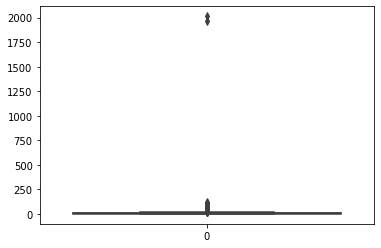

In [938]:
sns.boxplot(df_train.KitchenSquare)

In [939]:
df_train['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [940]:
df_train['KitchenSquare'].quantile(.975), df_train['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [941]:
condition = (df_train['KitchenSquare'].isna())\
            |(df_train['KitchenSquare']>df_train['KitchenSquare'].quantile(.975))
df_train.loc[condition, 'KitchenSquare'] = df_train['KitchenSquare'].median()
df_train.loc[df_train['KitchenSquare']<3, 'KitchenSquare'] = 3

In [942]:
df_train['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

### Обработка HouseFloor & Floor

In [943]:
df_train['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117], dtype=int8)

In [944]:
df_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [945]:
(df_train['Floor'] > df_train['HouseFloor']).sum()

1825

In [946]:
df_train['HouseFloor_outliers'] = 0
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor_outliers'] = 1
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'HouseFloor_outliers'] = 1

In [947]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()

In [948]:
floor_outliers = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index
floor_outliers

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [949]:
df_train.loc[floor_outliers, 'Floor'] = df_train.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [950]:
(df_train['Floor'] > df_train['HouseFloor']).sum()

0

### Обработка ' HouseYear'

In [951]:
df_train['HouseYear'].value_counts(ascending=True)

1928           1
1910           1
20052011       1
1947           1
4968           1
            ... 
2014         210
2015         299
2016         305
2017         308
1977        2652
Name: HouseYear, Length: 97, dtype: int64

In [952]:
df_train['HouseYear'].describe().round(2)

count       10000.00
mean         3990.17
std        200500.26
min          1910.00
25%          1974.00
50%          1977.00
75%          2001.00
max      20052011.00
Name: HouseYear, dtype: float64

In [953]:
df_train.loc[df_train['HouseYear'] > 2022]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,mean_square_per_room_in_dr,HouseFloor_outliers
1497,10814,109,1,37.265072,20.239714,9.0,9,12,20052011,0.136330,...,6141,10,262.0,3,6,B,254084.531250,0,37.265072,0
4189,11607,147,2,44.791836,28.360394,5.0,4,9,4968,0.319809,...,4756,16,2857.0,5,8,B,243028.609375,0,22.395918,0


In [954]:
def df_fix_house_year_manual(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

In [955]:
df_fix_house_year_manual(df_train)
df_train['HouseYear'].describe().round(2)

count    10000.00
mean      1984.87
std         18.41
min       1910.00
25%       1974.00
50%       1977.00
75%       2001.00
max       2020.00
Name: HouseYear, dtype: float64

### Обработка пропусков

In [956]:
# количество пропусков по свойствам
df_train.isna().sum()

Id                               0
DistrictId                       0
Rooms                            0
Square                           0
LifeSquare                    2113
KitchenSquare                    0
Floor                            0
HouseFloor                       0
HouseYear                        0
Ecology_1                        0
Ecology_2                        0
Ecology_3                        0
Social_1                         0
Social_2                         0
Social_3                         0
Healthcare_1                  4798
Helthcare_2                      0
Shops_1                          0
Shops_2                          0
Price                            0
Rooms_outlier                    0
mean_square_per_room_in_dr       0
HouseFloor_outliers              0
dtype: int64

In [957]:
df_train[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981560,29.442751,6.0
1,65.683640,40.049541,8.0
2,44.947952,29.197611,3.0
3,53.352982,52.731510,9.0
4,39.649193,23.776169,7.0
5,80.384476,46.683720,12.0
6,62.254112,37.160378,7.0
7,80.312927,NaN,3.0
8,64.511436,NaN,3.0
9,46.461411,18.915552,8.0


In [958]:
df_train['LifeSquare_nan'] = df_train['LifeSquare'].isna()*1

condition = (df_train['LifeSquare'].isna()) & (~df_train['Square'].isna()) & (~df_train['KitchenSquare'].isna()) 
df_train.loc[condition, 'LifeSquare'] = df_train.loc[condition, 'Square'] - df_train.loc[condition, 'KitchenSquare']

In [959]:
df_train.isna().sum()

Id                               0
DistrictId                       0
Rooms                            0
Square                           0
LifeSquare                       0
KitchenSquare                    0
Floor                            0
HouseFloor                       0
HouseYear                        0
Ecology_1                        0
Ecology_2                        0
Ecology_3                        0
Social_1                         0
Social_2                         0
Social_3                         0
Healthcare_1                  4798
Helthcare_2                      0
Shops_1                          0
Shops_2                          0
Price                            0
Rooms_outlier                    0
mean_square_per_room_in_dr       0
HouseFloor_outliers              0
LifeSquare_nan                   0
dtype: int64

### Обработка пропусков Healthcare_1

In [962]:
df_train.drop('Healthcare_1', axis=1,inplace=True)

KeyError: "['Healthcare_1'] not found in axis"

In [963]:
df_train.isna().sum()

Id                            0
DistrictId                    0
Rooms                         0
Square                        0
LifeSquare                    0
KitchenSquare                 0
Floor                         0
HouseFloor                    0
HouseYear                     0
Ecology_1                     0
Ecology_2                     0
Ecology_3                     0
Social_1                      0
Social_2                      0
Social_3                      0
Helthcare_2                   0
Shops_1                       0
Shops_2                       0
Price                         0
Rooms_outlier                 0
mean_square_per_room_in_dr    0
HouseFloor_outliers           0
LifeSquare_nan                0
dtype: int64

### Обработка 'Square'

In [964]:
df_train['Square'].describe()

count    10000.000000
mean        56.315777
std         21.058731
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

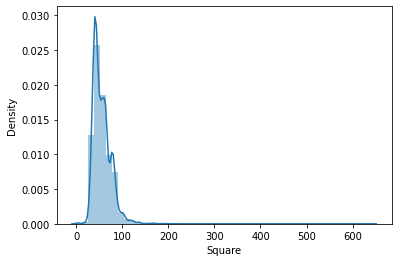

In [965]:
sns.distplot(df_train['Square'])
plt.show()

In [966]:
df_train.loc[df_train['Square'] > 150].nlargest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,mean_square_per_room_in_dr,HouseFloor_outliers,LifeSquare_nan
6977,11602,30,2,641.065186,638.163208,10.0,14,19,2019,0.000078,...,6398,141,3,23,B,133529.687500,0,320.532593,1,0
4262,28,9,2,604.705994,601.705994,3.0,17,18,1977,0.161532,...,5648,1,2,4,B,187717.250000,0,34.800576,0,1
4690,2307,102,1,409.425171,410.639740,10.0,4,4,2016,0.238617,...,3889,6,3,6,B,90470.429688,0,409.425171,0,0
1982,5548,86,5,275.645294,233.949310,6.0,12,37,2011,0.161976,...,7010,5,3,7,B,455264.875000,0,55.129059,0,0
1981,7917,27,1,212.932358,211.231125,3.0,2,3,2008,0.211401,...,1892,0,0,1,B,302211.250000,1,51.655229,0,0
9910,16568,27,4,200.334534,201.627365,6.0,1,2,2013,0.041116,...,14892,4,1,4,B,528560.500000,0,30.480761,0,0
8511,4249,23,5,198.930176,123.139862,10.0,1,2,2011,0.014073,...,475,0,0,0,B,345665.218750,0,34.344768,0,0
652,3718,56,3,190.857681,107.376167,6.0,3,3,2007,0.000000,...,5067,4,2,6,B,338644.062500,0,63.619227,1,0
7201,3233,129,4,186.692596,87.487083,6.0,3,3,2011,0.020741,...,5613,5,2,5,B,423443.468750,0,46.673149,0,0
5087,15947,129,4,185.906403,84.830078,6.0,2,3,2015,0.020741,...,5613,5,2,5,B,340273.250000,0,46.476601,1,0


In [967]:
def df_fix_square_manual(df):
    df.loc[df['Square'] > 150, 'Square'] = df.loc[df['Square'] > 150, 'Square'] / 10
    return df

In [968]:
df_fix_square_manual(df_train)
df_train['Square'].describe()

count    10000.000000
mean        55.797150
std         18.275709
min          1.136859
25%         41.712207
50%         52.384562
75%         65.820976
max        148.671936
Name: Square, dtype: float64

In [969]:
def df_fix_square(df):
    info_by_district_id = df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg(
        {'Square': 'mean'}).rename(
        columns={'Square': 'mean_square_rooms_dr'})

    df = pd.merge(df, info_by_district_id, on=[
        'DistrictId', 'Rooms', 'HouseYear'], how='left')

    df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Square'] \
        = df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Rooms'] \
        * df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'mean_square_per_room_in_dr']
    return df

In [970]:
sigma = 18.913301
df_fix_square(df_train)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,mean_square_per_room_in_dr,HouseFloor_outliers,LifeSquare_nan,mean_square_rooms_dr
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,5,0,11,B,184966.937500,0,21.677370,0,0,45.653687
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,1,1,16,B,300009.437500,0,19.874749,0,0,65.683640
2,4765,53,2,44.947952,29.197611,3.0,8,12,1968,0.049637,...,0,1,3,B,220925.906250,0,21.779555,0,0,46.461292
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,3,0,5,B,175616.234375,0,38.478086,0,0,67.293266
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,1,2,4,B,150226.531250,0,33.424255,0,0,38.632305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2,50.401787,30.476204,5.0,2,5,1968,0.135650,...,6,3,11,B,196684.312500,0,25.858324,1,0,48.798874
9996,6159,18,1,41.521545,20.539215,9.0,13,13,2000,0.000000,...,0,0,5,A,189050.296875,0,31.007321,0,0,41.521545
9997,5123,27,1,47.939007,44.939007,3.0,12,16,2015,0.072158,...,1,0,0,A,159143.812500,0,33.934160,0,1,43.470333
9998,5400,75,2,43.602562,33.840149,8.0,1,5,1961,0.307467,...,9,2,5,B,181595.343750,0,26.195452,0,0,43.975029


In [971]:
df_train = df_fix_square(df_train)

In [972]:
def prepare_lifesquare(df):
    df.loc[df['Square'] < df['LifeSquare'],'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square'] - df.loc[df['Square'] < df['LifeSquare'], 'KitchenSquare']
    return df


def fillna_life_square(df):
    df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())
    return df

In [973]:
prepare_lifesquare(df_train)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,mean_square_per_room_in_dr,HouseFloor_outliers,LifeSquare_nan,mean_square_rooms_dr
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,5,0,11,B,184966.937500,0,21.677370,0,0,45.653687
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,1,1,16,B,300009.437500,0,19.874749,0,0,65.683640
2,4765,53,2,44.947952,29.197611,3.0,8,12,1968,0.049637,...,0,1,3,B,220925.906250,0,21.779555,0,0,46.461292
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,3,0,5,B,175616.234375,0,38.478086,0,0,67.293266
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,1,2,4,B,150226.531250,0,33.424255,0,0,38.632305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2,50.401787,30.476204,5.0,2,5,1968,0.135650,...,6,3,11,B,196684.312500,0,25.858324,1,0,48.798874
9996,6159,18,1,41.521545,20.539215,9.0,13,13,2000,0.000000,...,0,0,5,A,189050.296875,0,31.007321,0,0,41.521545
9997,5123,27,1,47.939007,44.939007,3.0,12,16,2015,0.072158,...,1,0,0,A,159143.812500,0,33.934160,0,1,43.470333
9998,5400,75,2,43.602562,33.840149,8.0,1,5,1961,0.307467,...,9,2,5,B,181595.343750,0,26.195452,0,0,43.975029


In [974]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Id                          10000 non-null  int16   
 1   DistrictId                  10000 non-null  int16   
 2   Rooms                       10000 non-null  int32   
 3   Square                      10000 non-null  float64 
 4   LifeSquare                  10000 non-null  float64 
 5   KitchenSquare               10000 non-null  float32 
 6   Floor                       10000 non-null  int64   
 7   HouseFloor                  10000 non-null  int8    
 8   HouseYear                   10000 non-null  int32   
 9   Ecology_1                   10000 non-null  float32 
 10  Ecology_2                   10000 non-null  category
 11  Ecology_3                   10000 non-null  category
 12  Social_1                    10000 non-null  int8    
 13  Social_2         

### Обработка выбросов в LifeSquare

In [975]:
# обработка выбросов в LifeSquare
df_train['LifeSquare'].describe()

count    10000.000000
mean        39.738560
std         18.887111
min         -1.011057
25%         25.226431
50%         36.058706
75%         48.892022
max        148.965123
Name: LifeSquare, dtype: float64

In [976]:
df_train['LifeSquare'].value_counts(ascending=True)

29.442751     1
49.917637     1
27.281370     1
41.786327     1
21.118280     1
             ..
30.989753     2
77.794792     2
97.143548     3
148.965123    3
30.292156     5
Name: LifeSquare, Length: 9986, dtype: int64

In [977]:
df_train.loc[(df_train['LifeSquare'] < 10), 'LifeSquare'] = df_train['LifeSquare'].median()

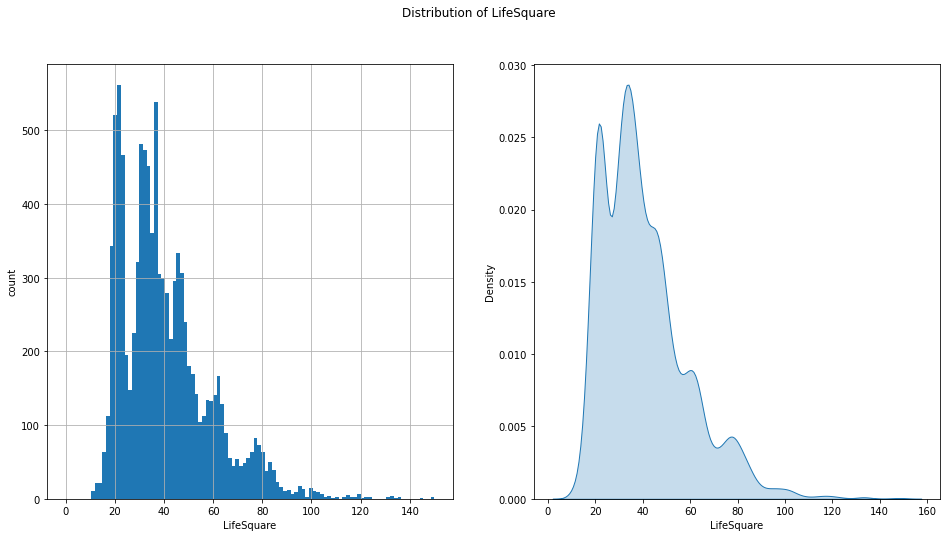

In [978]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df_train['LifeSquare'].hist( range=[0, 150],density=False, bins=100)
plt.ylabel('count')
plt.xlabel('LifeSquare')

plt.subplot(122)
sns.kdeplot(df_train['LifeSquare'], shade=True, legend=False)
plt.xlabel('LifeSquare')

plt.suptitle('Distribution of LifeSquare')
plt.show()

### Обзор номинативных переменных

In [987]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Id                          10000 non-null  int16   
 1   DistrictId                  10000 non-null  int16   
 2   Rooms                       10000 non-null  int32   
 3   Square                      10000 non-null  float64 
 4   LifeSquare                  10000 non-null  float64 
 5   KitchenSquare               10000 non-null  float32 
 6   Floor                       10000 non-null  int64   
 7   HouseFloor                  10000 non-null  int8    
 8   HouseYear                   10000 non-null  int32   
 9   Ecology_1                   10000 non-null  float32 
 10  Ecology_2                   10000 non-null  category
 11  Ecology_3                   10000 non-null  category
 12  Social_1                    10000 non-null  int8    
 13  Social_2         

In [988]:
df_obj_features = df_train.select_dtypes(include='category')
df_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [989]:
df_obj_features['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [990]:
df_obj_features['Ecology_2'].unique()

['B', 'A']
Categories (2, object): ['A', 'B']

In [991]:
df_obj_features['Ecology_2'].nunique()

2

In [992]:
df_obj_features['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [993]:
df_obj_features['Ecology_3'].unique()

['B', 'A']
Categories (2, object): ['A', 'B']

In [994]:
df_obj_features['Ecology_3'].nunique()

2

In [995]:
df_obj_features['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [996]:
df_obj_features['Shops_2'].unique()

['B', 'A']
Categories (2, object): ['A', 'B']

In [997]:
df_obj_features['Shops_2'].nunique()

2

In [ ]:
class DataPreprocessing:
    """Подготовка  исходных  данных"""
    def __init__(self):
    """Параметры класса"""
        self.median=None
        self.kitchen_square_quantile=None
    
    def fit(self,X):
        """Сохранение статистик"""
        #расчет медиан
        self.median = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self,X):
        """Трансформация данных"""
        
        #Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0)|(X['Rooms'] > 6), 'Rooms_outlier'] = 1
    
        X.loc[(X['Rooms'] == 0), 'Rooms'] = 1
        X.loc[(X['Rooms'] >= 0), 'Rooms'] = self.medians['Rooms']    
        
        #KitchenSquare
        condition = (X['KitchenSquare'].isna())\
                    |(X['KitchenSquare']>self.kitchen_square_quantile)
                
                      
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare']<3, 'KitchenSquare'] = 3
        
        
        #HouseFloor,   Floor
        
        X['HouseFloor_outliers'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outliers'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outliers'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outliers'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index

              
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        #HouseYear
        current_year = datetime.now().year
        X['HouseYear_outlier'] = 0
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        #Healthcare_1
        if 'Healthcare_1' in X.columns":        
                X.drop('Healthcare_1', axis=1, inplace=True)
        
        # LifeSquare
        
        X['LifeSquare_nan'] = X['LifeSquare'].isna()*1
        condition = (X['LifeSquare'].isna()) & \
                        (~X['Square'].isna()) & \
                        (~X['KitchenSquare'].isna()) 
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare']
        
        
        
        X.fillna(self.medians, inplace=True)
        
        return X
        

### Построение новых  признаков

#### Dummies

In [998]:
binary_to_numbers = {'A': 0, 'B': 1}
df_train['Ecology_2'] = df_train['Ecology_2'].replace(binary_to_numbers)
df_train['Ecology_3'] = df_train['Ecology_3'].replace(binary_to_numbers)
df_train['Shops_2'] = df_train['Shops_2'].replace(binary_to_numbers)

### DistrictSize, IsDistrictLaege

In [999]:
district_size = df_train['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [1000]:
df_train = df_train.merge(district_size, on='DistrictId', how='left')

In [1001]:
(df_train['DistrictSize']>100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [1002]:
df_train['IsDistrictLaege'] = (df_train['DistrictSize']>100).astype(int)

In [1003]:
df_train.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,mean_square_per_room_in_dr,HouseFloor_outliers,LifeSquare_nan,mean_square_rooms_dr,DistrictSize,IsDistrictLaege
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,11,1,184966.937500,0,21.677370,0,0,45.653687,22,0
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,16,1,300009.437500,0,19.874749,0,0,65.683640,87,0
2,4765,53,2,44.947952,29.197611,3.0,8,12,1968,0.049637,...,3,1,220925.906250,0,21.779555,0,0,46.461292,174,1
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,5,1,175616.234375,0,38.478086,0,0,67.293266,179,1
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,4,1,150226.531250,0,33.424255,0,0,38.632305,97,0
5,12915,59,3,80.384476,46.683720,12.0,5,17,2011,0.309479,...,6,1,215898.453125,0,27.611833,0,0,83.112770,67,0
6,14549,154,2,62.254112,37.160378,7.0,3,5,1960,0.460556,...,5,1,296021.218750,0,31.127056,0,0,62.254112,10,0
7,11993,74,2,80.312927,77.312927,3.0,8,13,1977,0.075779,...,2,1,221244.156250,0,41.875109,1,1,77.154152,114,1
8,5172,1,2,64.511436,61.511436,3.0,9,17,1977,0.007122,...,1,1,229102.796875,0,33.381183,0,1,64.187279,652,1
9,8649,23,1,46.461411,18.915552,8.0,13,17,2014,0.075779,...,2,1,95380.218750,0,33.802490,0,0,42.201286,565,1


### MedPriceByDistrict

In [1004]:
med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'})\
                .rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1,142799.437500
1,0,2,176210.812500
2,0,3,300610.359375
3,1,1,146735.671875
4,1,2,202666.312500


In [1005]:
df_train = df_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df_train.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,mean_square_per_room_in_dr,HouseFloor_outliers,LifeSquare_nan,mean_square_rooms_dr,DistrictSize,IsDistrictLaege,MedPriceByDistrict
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,1,184966.937500,0,21.677370,0,0,45.653687,22,0,207786.132812
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,1,300009.437500,0,19.874749,0,0,65.683640,87,0,300009.437500
2,4765,53,2,44.947952,29.197611,3.0,8,12,1968,0.049637,...,1,220925.906250,0,21.779555,0,0,46.461292,174,1,263206.218750
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,1,175616.234375,0,38.478086,0,0,67.293266,179,1,166809.671875
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,1,150226.531250,0,33.424255,0,0,38.632305,97,0,158539.054688
5,12915,59,3,80.384476,46.683720,12.0,5,17,2011,0.309479,...,1,215898.453125,0,27.611833,0,0,83.112770,67,0,466753.625000
6,14549,154,2,62.254112,37.160378,7.0,3,5,1960,0.460556,...,1,296021.218750,0,31.127056,0,0,62.254112,10,0,234421.453125
7,11993,74,2,80.312927,77.312927,3.0,8,13,1977,0.075779,...,1,221244.156250,0,41.875109,1,1,77.154152,114,1,243031.695312
8,5172,1,2,64.511436,61.511436,3.0,9,17,1977,0.007122,...,1,229102.796875,0,33.381183,0,1,64.187279,652,1,202666.312500
9,8649,23,1,46.461411,18.915552,8.0,13,17,2014,0.075779,...,1,95380.218750,0,33.802490,0,0,42.201286,565,1,102069.273438


In [1021]:
# def floor_to_cat(X):
    
#     X['floor_cat'] = 0
    
#     X.loc[X['Floor'] <=3, 'floor_cat'] = 1
#     X.loc[(X['Floor'] > 3) &  (X['Floor'] <= 5),'floor_cat'] = 2
#     X.loc[(X['Floor'] > 5) &  (X['Floor'] <= 9),'floor_cat'] = 3
#     X.loc[(X['Floor'] > 5) &  (X['Floor'] <= 15),'floor_cat'] = 4
#     X.loc[X['Floor'] > 15, 'floor_cat'] = 5
    
#     return X

# def floor_to_cat_pandas(X):
    
#     X['floor_cat'] = 0
#     bins = [0, 3, 5, 9, 15, X['Floor'].max()]
#     X['floor_cat'] = pd.cut(X['Floor'], bins= bins, labels=False)
    
#     X['floor_cat'].fillna(-1, inplase=True)
    
#     return X

# def year_to_cat(X):
    
#     X['year_cat'] = 0
    
#     X.loc[X['HouseYear'] <=1941, 'floor_cat'] = 1
#     X.loc[(X['HouseYear'] > 1941) &  (X['HouseYear'] <= 1945),'year_cat'] = 2
#     X.loc[(X['HouseYear'] > 1945) &  (X['HouseYear'] <= 1980),'year_cat'] = 3
#     X.loc[(X['HouseYear'] > 1980) &  (X['HouseYear'] <= 2000),'year_cat'] = 4
#     X.loc[(X['HouseYear'] > 2000) &  (X['HouseYear'] <= 2010),'year_cat'] = 5
#     X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
    
#     return X

# def year_to_cat_pandas(X):
    
#     X['year_cat'] = 0
#     bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
#     X['year_cat'] = pd.cut(X['HouseYear'], bins= bins, labels=False)
    
#     X['year_cat'].fillna(-1, inplase=True)
    
#     return X
    

In [1022]:
bins = [0, 3, 5, 9, 15, df_train['Floor'].max()]
pd.cut(df_train['Floor'], bins= bins, labels=False)

0       2
1       2
2       2
3       2
4       3
       ..
9995    0
9996    3
9997    3
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [1023]:
bins = [0, 3, 5, 9, 15, df_train['Floor'].max()]
pd.cut(df_train['Floor'], bins= bins)

0        (5, 9]
1        (5, 9]
2        (5, 9]
3        (5, 9]
4       (9, 15]
         ...   
9995     (0, 3]
9996    (9, 15]
9997    (9, 15]
9998     (0, 3]
9999     (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64, right]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [1024]:
bins = [0, 1941, 1945, 1980, 2000, 2010, df_train['HouseYear'].max()]
pd.cut(df_train['HouseYear'], bins= bins, labels=False)

0       2
1       2
2       2
3       2
4       2
       ..
9995    2
9996    3
9997    5
9998    2
9999    3
Name: HouseYear, Length: 10000, dtype: int64

In [1025]:
df_train = floor_to_cat(df_train)
df_train = year_to_cat(df_train)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,mean_square_per_room_in_dr,HouseFloor_outliers,LifeSquare_nan,mean_square_rooms_dr,DistrictSize,IsDistrictLaege,MedPriceByDistrict,floor_cat,year_cat
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,0,21.677370,0,0,45.653687,22,0,207786.132812,4,3
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,0,19.874749,0,0,65.683640,87,0,300009.437500,4,3
2,4765,53,2,44.947952,29.197611,3.0,8,12,1968,0.049637,...,0,21.779555,0,0,46.461292,174,1,263206.218750,4,3
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,0,38.478086,0,0,67.293266,179,1,166809.671875,4,3
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,0,33.424255,0,0,38.632305,97,0,158539.054688,4,3


In [1030]:
med_price_by_floor_year = df_train.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price': 'median'})\
                                            .rename(columns={'Price': 'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,0,1,343812.500000
1,2,1,467230.531250
2,2,2,509182.968750
3,3,1,179032.671875
4,3,2,189443.500000


In [1031]:
df_train = df_train.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
df_train.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,mean_square_per_room_in_dr,HouseFloor_outliers,LifeSquare_nan,mean_square_rooms_dr,DistrictSize,IsDistrictLaege,MedPriceByDistrict,floor_cat,year_cat,MedPriceByFloorYear
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,21.677370,0,0,45.653687,22,0,207786.132812,4,3,188319.656250
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,19.874749,0,0,65.683640,87,0,300009.437500,4,3,188319.656250
2,4765,53,2,44.947952,29.197611,3.0,8,12,1968,0.049637,...,21.779555,0,0,46.461292,174,1,263206.218750,4,3,188319.656250
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,38.478086,0,0,67.293266,179,1,166809.671875,4,3,188319.656250
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,33.424255,0,0,38.632305,97,0,158539.054688,4,3,188319.656250
5,12915,59,3,80.384476,46.683720,12.0,5,17,2011,0.309479,...,27.611833,0,0,83.112770,67,0,466753.625000,2,6,163788.046875
6,14549,154,2,62.254112,37.160378,7.0,3,5,1960,0.460556,...,31.127056,0,0,62.254112,10,0,234421.453125,1,3,179032.671875
7,11993,74,2,80.312927,77.312927,3.0,8,13,1977,0.075779,...,41.875109,1,1,77.154152,114,1,243031.695312,4,3,188319.656250
8,5172,1,2,64.511436,61.511436,3.0,9,17,1977,0.007122,...,33.381183,0,1,64.187279,652,1,202666.312500,4,3,188319.656250
9,8649,23,1,46.461411,18.915552,8.0,13,17,2014,0.075779,...,33.802490,0,0,42.201286,565,1,102069.273438,4,6,173213.281250


### Отбор признаков

In [1033]:
df_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'mean_square_per_room_in_dr',
 'HouseFloor_outliers',
 'LifeSquare_nan',
 'mean_square_rooms_dr',
 'DistrictSize',
 'IsDistrictLaege',
 'MedPriceByDistrict',
 'floor_cat',
 'year_cat',
 'MedPriceByFloorYear']

In [ ]:
feature_name = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1',
                 'Shops_2',]
new_feature_name = ['Rooms_outlier',  'mean_square_per_room_in_dr',  'HouseFloor_outliers',  'LifeSquare_nan', 'mean_square_rooms_dr',
                     'DistrictSize', 'IsDistrictLaege',  'MedPriceByDistrict',  'floor_cat',  'year_cat',
                         'MedPriceByFloorYear']
target_name = 'Price'

### Разбиение на train  и test

In [1043]:
X = df_train.drop ('Price', axis=1)
y = df_train['Price']

In [1045]:
X.head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,mean_square_per_room_in_dr,HouseFloor_outliers,LifeSquare_nan,mean_square_rooms_dr,DistrictSize,IsDistrictLaege,MedPriceByDistrict,floor_cat,year_cat,MedPriceByFloorYear
0,14038,35,2,47.98156,29.442751,6.0,7,9,1969,0.08904,...,21.677370,0,0,45.653687,22,0,207786.132812,4,3,188319.65625
1,15053,41,3,65.68364,40.049541,8.0,7,9,1978,0.00007,...,19.874749,0,0,65.683640,87,0,300009.437500,4,3,188319.65625


In [1051]:
X_train, X_valid, y_train, y_valid, = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape
print(f'Получили  тренировочный датафрейм (X_train, y_train)  - {X_train.shape}, {y_train.shape} и тестовые (X_test, y_test) - {X_valid.shape}, {y_valid.shape}')

Получили  тренировочный датафрейм (X_train, y_train)  - (6700, 29), (6700,) и тестовые (X_test, y_test) - (3300, 29), (3300,)


### Создание модели

In [1053]:
#Создаybt моделb под названием rf_model с помощью класса RandomForestRegressor из модуля sklearn.ensemble
rf_model = RandomForestRegressor(random_state=42, criterion = 'squared_error')  
#обучение модели
rf_model.fit (X_train, y_train)
                               

RandomForestRegressor(random_state=42)

In [1054]:
#предсказание train и valid и обучение модели 
y_train_preds = rf_model.predict(X_train)
y_tast_preds = rf_model.predict(X_valid) 


In [ ]:
def evaluate_r2(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    print("Коэффициент детерминации R2:\t" + str(round(r2(true_values, pred_values), 3)))
    return round(r2(true_values, pred_values), 3)

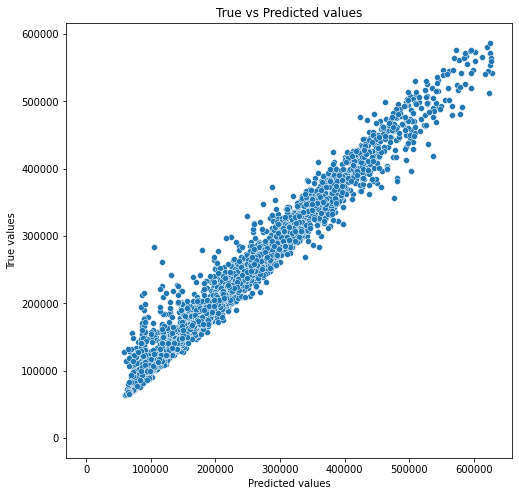

Коэффициент детерминации R2:	0.965


In [1055]:
#оценка качества модели на train
plt.figure(figsize=(8,8))

pred_values = y_train
true_values = y_train_preds
sns.scatterplot(x = pred_values, y = true_values)
plt.plot([5,45], [5, 45], linestyle='--', color='black')  # диагональ, где true_values = pred_values


plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('True vs Predicted values')
plt.show()


r2_rf = evaluate_r2(y_train, y_train_preds)

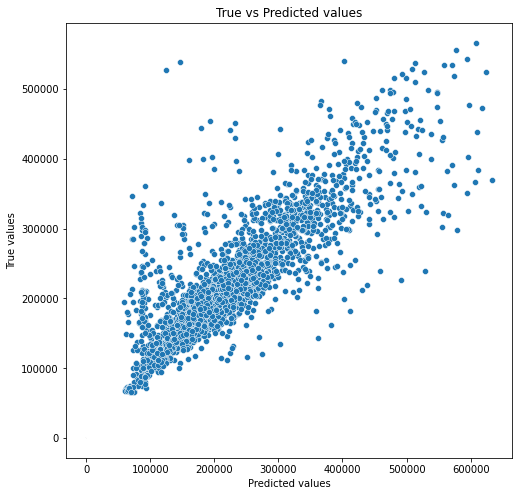

Коэффициент детерминации R2:	0.722


In [1058]:
#оценка качества модели на test
plt.figure(figsize=(8,8))

pred_values = y_valid
true_values = y_tast_preds
sns.scatterplot(x = pred_values, y = true_values)
plt.plot([5,45], [5, 45], linestyle='--', color='black')  # диагональ, где true_values = pred_values

plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('True vs Predicted values')
plt.show()

r2_rf = evaluate_r2(y_valid, y_tast_preds)

### Кросс валидация

In [1063]:
from sklearn.model_selection import cross_val_score

In [1064]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring= 'r2', cv = KFold(n_splits=3, shuffle= True))
cv_score                                                                           

array([0.70361895, 0.75650593, 0.75642235])

In [1065]:
cv_score.mean()

0.7388490748182441

### Важность признаков

In [1068]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_),
                                  columns = ['feature_name', 'importances'])
feature_importances.sort_values(by='importances', ascending=False)

,feature_name,importances
25,MedPriceByDistrict,0.623473
3,Square,0.095642
19,mean_square_per_room_in_dr,0.033186
22,mean_square_rooms_dr,0.026945
4,LifeSquare,0.025049
14,Social_3,0.020751
0,Id,0.020127
7,HouseFloor,0.014902
8,HouseYear,0.014640
28,MedPriceByFloorYear,0.013872


### Прогнозирование на тестовом датасете

In [1073]:
df_test.shape

(5000, 19)

In [1075]:
submit = pd.read_csv('rf_submit.csv')

In [ ]:
predictions = rf_model.predict(df_test)
predictions

In [ ]:
submit.to_csv(rf_submit_1.csv, index=False)

In [ ]:
with open('rf_final_model', 'wb') as file:
          pickle.dump('rf_final_model', file)

In [ ]:
with open('preprocessor_model', 'wb') as file:
          pickle.dump('preprocessor', file)